# Data 586 Project
##### Authors: Matthew, Kyle, Shayla

#### Goal: Build an R-CNN to conduct object recognition for red blood cells (RBC), white blood cells (WBC), and platelets.

#### Dataset: Utilizing the BCCD dataset that is publicly available at https://github.com/Shenggan/BCCD_Dataset

## Workflow

### 1. Extracting Data using custom built function

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import xml.etree.ElementTree as ET
from torchvision.transforms import functional as F

class BCCDDataset(torch.utils.data.Dataset):
    def __init__(self, root, image_set, transforms=None):
        self.root = os.path.join(root, 'BCCD')
        self.transforms = transforms
        # Path to images and annotations
        self.imgs_dir = os.path.join(self.root, 'JPEGImages')
        self.annos_dir = os.path.join(self.root, 'Annotations')
        
        # Read the split file
        split_file = os.path.join(self.root, 'ImageSets', 'Main', f'{image_set}.txt')
        with open(split_file, 'r') as f:
            self.imgs_ids = f.read().splitlines()
    
    def __getitem__(self, idx):
        # Image ID
        img_id = self.imgs_ids[idx]
        # Image and annotation paths
        img_path = os.path.join(self.imgs_dir, f'{img_id}.jpg')
        anno_path = os.path.join(self.annos_dir, f'{img_id}.xml')
        
        # Load image
        img = Image.open(img_path).convert("RGB")
        
        # Parse annotation
        tree = ET.parse(anno_path)
        root = tree.getroot()
        boxes = []
        labels = []
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            
            # Check if the bounding box is valid
            if xmax <= xmin or ymax <= ymin:
                # Skip this bounding box
                continue
            
            boxes.append([xmin, ymin, xmax, ymax])
            
            label = obj.find('name').text
            if label == 'RBC':
                labels.append(1)
            elif label == 'WBC':
                labels.append(2)
            else:  # Platelets
                labels.append(3)

        if not boxes:
            # Handle the case where all boxes are invalid
            # For example, return a dummy box or raise an error
            boxes = [[0, 0, 1, 1]]  # Example dummy box
            labels = [0]  # Background class

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs_ids)

train = BCCDDataset(root='dataset', image_set='train', transforms=lambda x, y: (F.to_tensor(x), y)) # 205 observations
val = BCCDDataset(root='dataset', image_set='val', transforms=lambda x, y: (F.to_tensor(x), y)) # 87 observations
test = BCCDDataset(root='dataset', image_set='test', transforms=lambda x, y: (F.to_tensor(x), y)) # 72 observations

#### Testing to see what the image tensors look like

In [2]:
img, target = train[0]  # Access the first item in the dataset

In [3]:
img.shape

torch.Size([3, 480, 640])

In [4]:
print(target)

{'boxes': tensor([[ 68., 315., 286., 480.],
        [346., 361., 446., 454.],
        [ 53., 179., 146., 299.],
        [449., 400., 536., 480.],
        [461., 132., 548., 212.],
        [454., 295., 541., 375.],
        [417., 283., 508., 383.],
        [278., 342., 369., 451.],
        [545.,  62., 636., 159.],
        [485.,  91., 576., 188.],
        [376., 171., 438., 253.],
        [329., 177., 395., 271.],
        [291.,  59., 407., 168.],
        [299.,   1., 404.,  68.],
        [346.,  26., 449., 138.],
        [134.,   1., 241.,  95.],
        [  1.,  38.,  98., 164.],
        [165., 160., 257., 264.],
        [464., 209., 566., 319.]]), 'labels': tensor([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'area': tensor([35970.,  9300., 11160.,  6960.,  6960.,  6960.,  9100.,  9919.,  8827.,
         8827.,  5084.,  6204., 12644.,  7035., 11536., 10058., 12222.,  9568.,
        11220.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), '

In [5]:
print(img)

tensor([[[0.6784, 0.6706, 0.6627,  ..., 0.6980, 0.7020, 0.6980],
         [0.6824, 0.6745, 0.6627,  ..., 0.6980, 0.6980, 0.6980],
         [0.6863, 0.6784, 0.6667,  ..., 0.7020, 0.6980, 0.6941],
         ...,
         [0.7490, 0.7529, 0.7647,  ..., 0.8353, 0.8196, 0.8039],
         [0.7686, 0.7765, 0.7882,  ..., 0.8431, 0.8235, 0.8118],
         [0.7882, 0.7961, 0.8039,  ..., 0.8510, 0.8275, 0.8157]],

        [[0.6118, 0.6039, 0.5922,  ..., 0.6275, 0.6275, 0.6235],
         [0.6157, 0.6078, 0.5922,  ..., 0.6275, 0.6235, 0.6235],
         [0.6157, 0.6078, 0.5961,  ..., 0.6314, 0.6235, 0.6196],
         ...,
         [0.7451, 0.7490, 0.7608,  ..., 0.8196, 0.8039, 0.8000],
         [0.7765, 0.7843, 0.7961,  ..., 0.8275, 0.8118, 0.8000],
         [0.8000, 0.8078, 0.8118,  ..., 0.8314, 0.8157, 0.8039]],

        [[0.5020, 0.5020, 0.4980,  ..., 0.6275, 0.6431, 0.6392],
         [0.5137, 0.5059, 0.5059,  ..., 0.6275, 0.6314, 0.6392],
         [0.5216, 0.5137, 0.5176,  ..., 0.6314, 0.6314, 0.

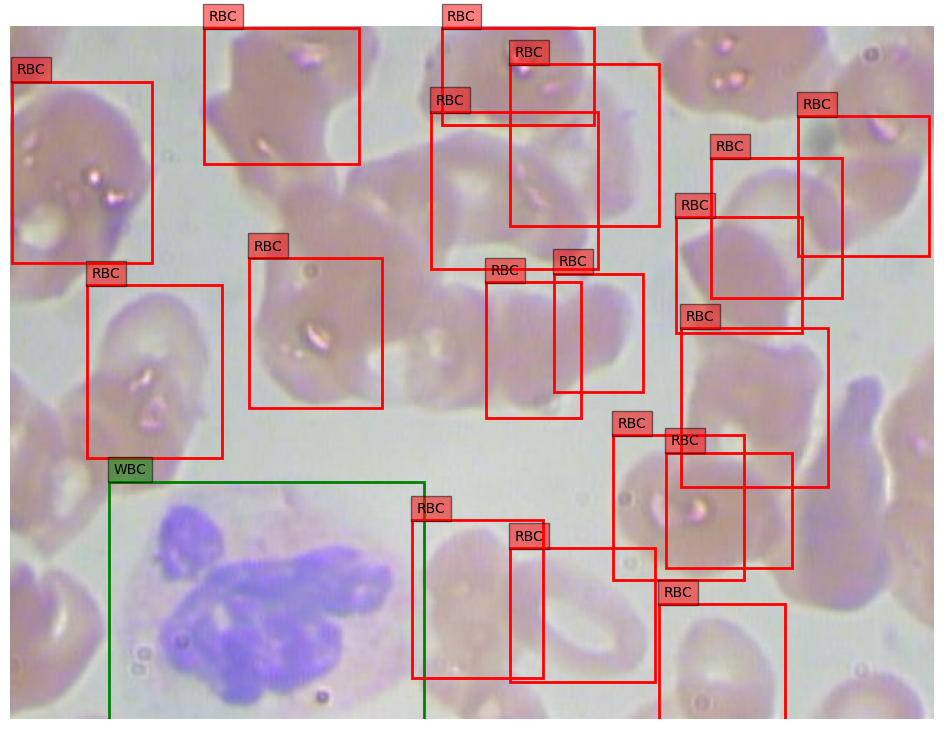

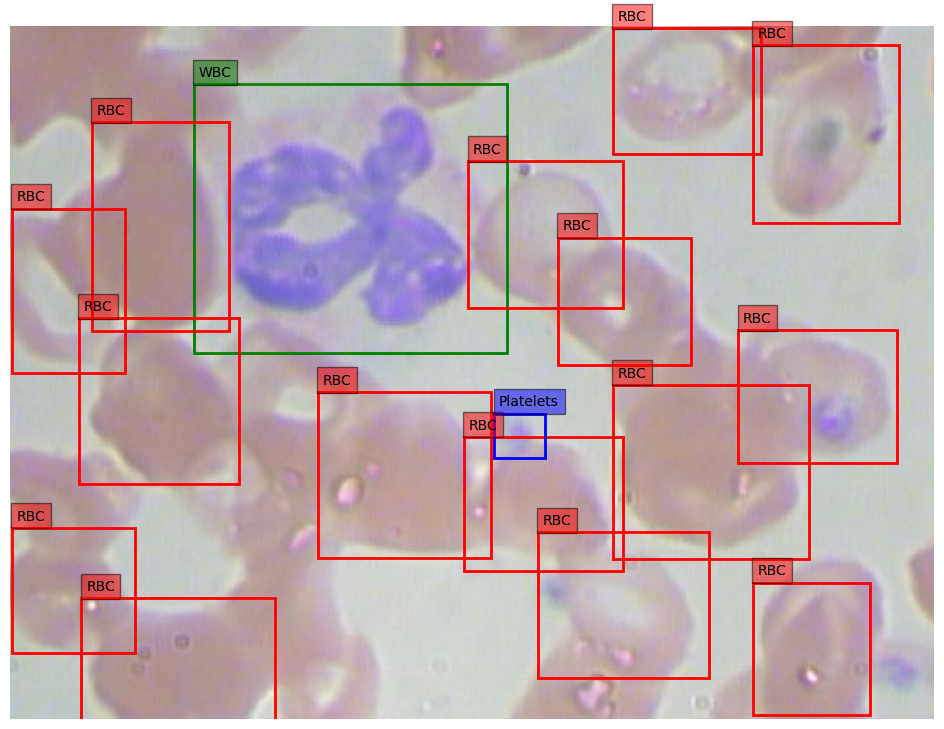

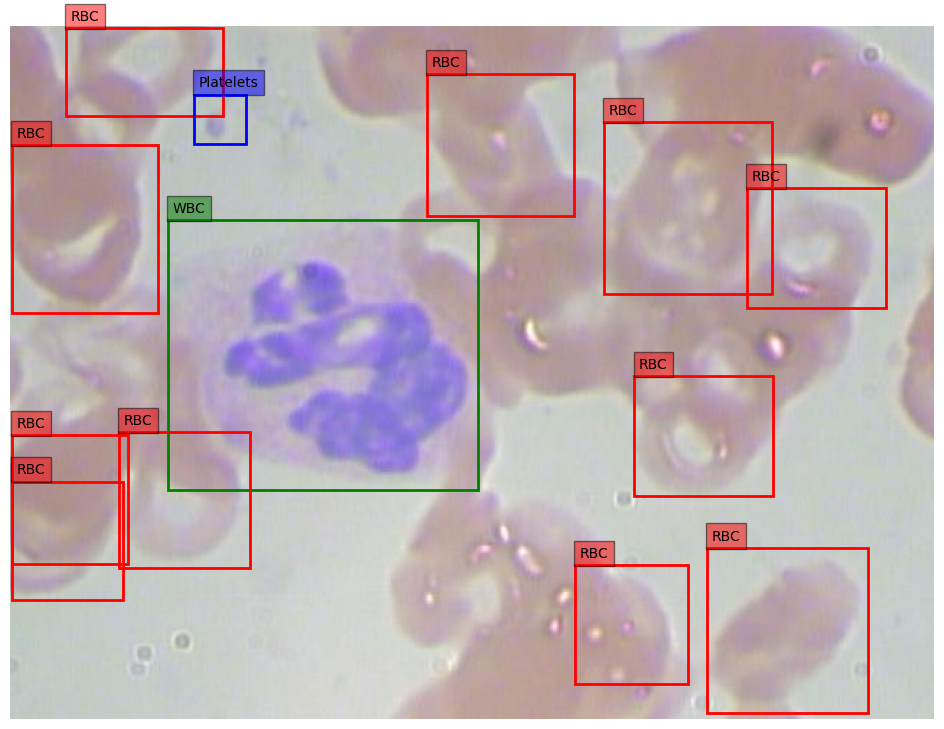

In [6]:
# Visualize the first three images in the training set
for i in range(3):   
    img = Image.fromarray(train[i][0].mul(255).permute(1, 2, 0).byte().numpy())
    np_image = np.array(img)
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(np_image)

    # Get the bounding boxes and labels from the target
    boxes = train[i][1]["boxes"].numpy()
    labels =  train[i][1]["labels"].numpy()

    # Create a dictionary to map the label numbers to their original names
    label_dict = {1: 'RBC', 2: 'WBC', 3: 'Platelets'}

    # Define the colors for each class
    colors = ['r', 'g', 'b']

    # For each bounding box and label, add a rectangle and text to the plot
    for box, label in zip(boxes, labels):
        color = colors[label-1]
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0]+3.25, box[1]-5.5, label_dict[label], color='black', bbox=dict(facecolor=color, alpha=0.5))
    
    plt.axis('off')
    plt.show()

### 2. Exploratory data analysis

#### Check the distribution of blood cell in each dataset

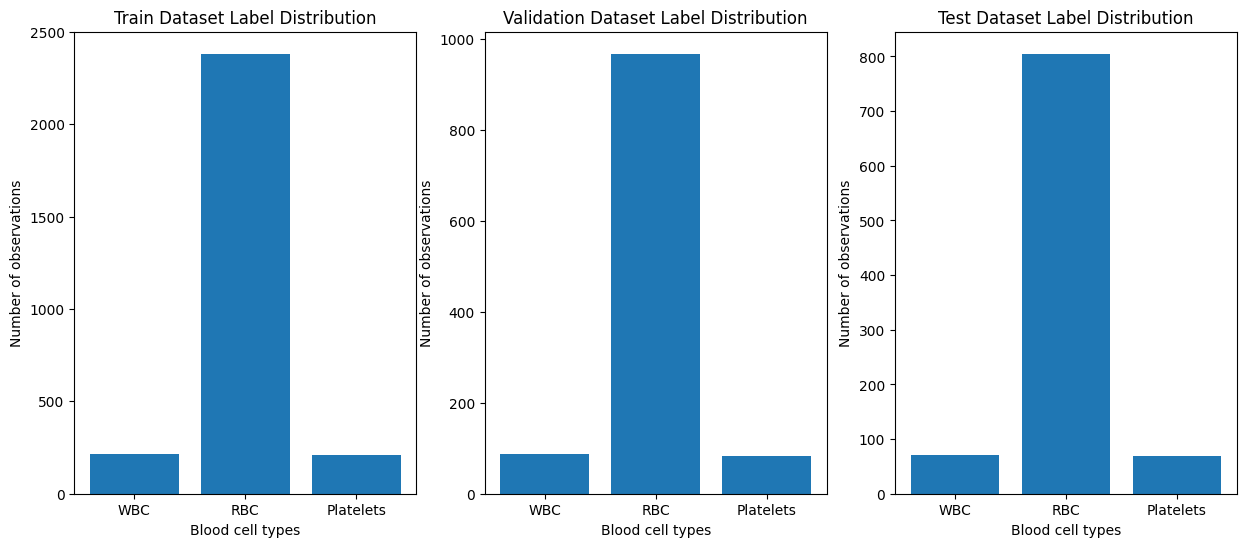

In [7]:
def get_label_distribution(dataset):    # Extract labels from the dataset
    labels = []
    for _, target in dataset:
        labels.extend(target["labels"].tolist())
    return labels

label_dict = {1: 'RBC', 2: 'WBC', 3: 'Platelets'}

train_labels = [label_dict[label] for label in get_label_distribution(train)]   # Get the label distribution and convert the labels to their blood cell types
val_labels = [label_dict[label] for label in get_label_distribution(val)]
test_labels = [label_dict[label] for label in get_label_distribution(test)]

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.hist(train_labels, bins=range(4), align='left', rwidth=0.8)
plt.xlabel("Blood cell types")
plt.ylabel("Number of observations")
plt.title('Train Dataset Label Distribution')

plt.subplot(1, 3, 2)
plt.hist(val_labels, bins=range(4), align='left', rwidth=0.8)
plt.xlabel("Blood cell types")
plt.ylabel("Number of observations")
plt.title('Validation Dataset Label Distribution')

plt.subplot(1, 3, 3)
plt.hist(test_labels, bins=range(4), align='left', rwidth=0.8)
plt.xlabel("Blood cell types")
plt.ylabel("Number of observations")
plt.title('Test Dataset Label Distribution')

plt.show()

Red blood cells clearly dominate the number of observations across the training and testing set, while the other two blood cell types are relatively balanced.

#### Check the distribution of number of blood cell detections across all images

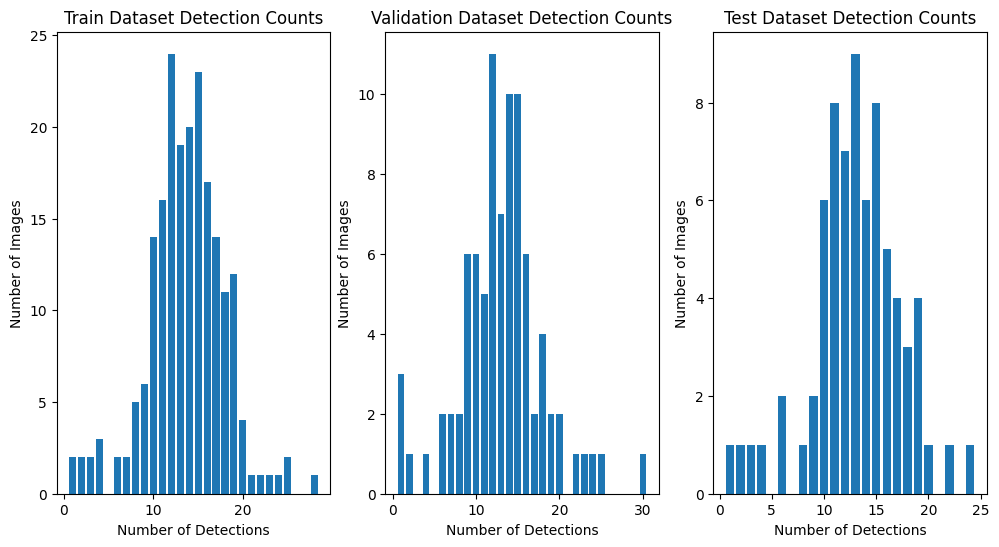

In [8]:
def get_detection_counts(dataset): 
    counts = []
    for _, target in dataset:
        counts.append(len(target["labels"]))
    return counts

train_counts = get_detection_counts(train)
val_counts = get_detection_counts(val)
test_counts = get_detection_counts(test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(train_counts, bins=range(1, max(train_counts)+2), align='left', rwidth=0.8)
plt.title('Train Dataset Detection Counts')
plt.xlabel('Number of Detections')
plt.ylabel('Number of Images')

plt.subplot(1, 3, 2)
plt.hist(val_counts, bins=range(1, max(val_counts)+2), align='left', rwidth=0.8)
plt.title('Validation Dataset Detection Counts')
plt.xlabel('Number of Detections')
plt.ylabel('Number of Images')

plt.subplot(1, 3, 3)
plt.hist(test_counts, bins=range(1, max(test_counts)+2), align='left', rwidth=0.8)
plt.title('Test Dataset Detection Counts')
plt.xlabel('Number of Detections')
plt.ylabel('Number of Images')

plt.show()

There are 10-19 blood cell detections in most of the images.

### 3. Model set-up

Utilizing the pre-trained Faster R-CNN model as the starting point, and will fine tune based on our specific blood cells dataset.

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # Load a pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    # Replace the classifier with a new one, that has
    # num_classes which is user-defined
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Check the device available in the machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # else "mps" if torch.backends.mps.is_available() else "cpu")

### 4. Optimizer Tuning
Tuning the optimizer(SGD, Adam, AdamW) \
Use mean average precision(mAP) from the validation set to determine the best optimizer

#### SGD

In [13]:
from torch.optim import SGD, Adam, AdamW
from torch.utils.data import DataLoader
import utils_ObjectDetection as utils
from tqdm import tqdm

# Define a function that returns the predictions with a score greater than a threshold
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

# Prepare data loaders
train_loader = DataLoader(train, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x))) 
test_loader = DataLoader(test, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Initalize a dictionary to store the result of 3 different optimizers
results = {}

# Initialize the model and optimizer
model = get_model_instance_segmentation(num_classes=4) # 3 classes (RBC, WBC, Platelets) + background
model.to(device)
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()

    for images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluate the model on the validation set
labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(val_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    annot = [{k: v.to(device) for k, v in t.items()} for t in annot]
    
    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5) # Only keep predictions with a score > 0.5
        preds_adj = [{k: v.to(device) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)
        
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated

true_positives = true_positives.to(device)
pred_scores = pred_scores.to(device)
pred_labels = pred_labels.to(device)
labels_tensor = torch.tensor(labels).to(device)

precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, labels_tensor)
mAP = torch.mean(AP.float())
print(f'mAP : {mAP}')
print(f'AP : {AP}')
results['SGD'] = {'mAP': mAP.item(), 'AP': AP.tolist()}

100%|██████████| 87/87 [01:14<00:00,  1.16it/s]

mAP : 0.8859941959381104
AP : tensor([0.8463, 0.9953, 0.8164])


#### Adam

In [14]:
# Initialize the model and optimizer
model = get_model_instance_segmentation(num_classes=4) # 3 classes (RBC, WBC, Platelets) + background
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()

    for images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluate the model on the validation set
labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(val_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    annot = [{k: v.to(device) for k, v in t.items()} for t in annot]
    
    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5) # Only keep predictions with a score > 0.5
        preds_adj = [{k: v.to(device) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)
        
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated

true_positives = true_positives.to(device)
pred_scores = pred_scores.to(device)
pred_labels = pred_labels.to(device)
labels_tensor = torch.tensor(labels).to(device)

precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, labels_tensor)
mAP = torch.mean(AP.float())
print(f'mAP : {mAP}')
print(f'AP : {AP}')
results['Adam'] = {'mAP': mAP.item(), 'AP': AP.tolist()}

100%|██████████| 87/87 [01:20<00:00,  1.08it/s]

mAP : 0.8425779938697815
AP : tensor([0.7700, 0.9908, 0.7669])


#### AdamW

In [15]:
# Initialize the model and optimizer
model = get_model_instance_segmentation(num_classes=4) # 3 classes (RBC, WBC, Platelets) + background
model.to(device)
optimizer = AdamW(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()

    for images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluate the model on the validation set
labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(val_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    annot = [{k: v.to(device) for k, v in t.items()} for t in annot]
    
    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5) # Only keep predictions with a score > 0.5
        preds_adj = [{k: v.to(device) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)
        
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated

true_positives = true_positives.to(device)
pred_scores = pred_scores.to(device)
pred_labels = pred_labels.to(device)
labels_tensor = torch.tensor(labels).to(device)

precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, labels_tensor)
mAP = torch.mean(AP.float())
print(f'mAP : {mAP}')
print(f'AP : {AP}')
results['AdamW'] = {'mAP': mAP.item(), 'AP': AP.tolist()}

100%|██████████| 87/87 [01:20<00:00,  1.08it/s]

mAP : 0.8662503361701965
AP : tensor([0.8105, 0.9945, 0.7938])


#### Optimizer comparison with mAP@0.5

In [16]:
for optimizer_name, metrics in results.items():
    print(f"Optimizer: {optimizer_name}, mAP: {metrics['mAP']}, AP: {metrics['AP']}")

Optimizer: SGD, mAP: 0.8859941959381104, AP: [0.8462945222854614, 0.9952978491783142, 0.8163902759552002]
Optimizer: Adam, mAP: 0.8425779938697815, AP: [0.7700074911117554, 0.9908017516136169, 0.7669247984886169]
Optimizer: AdamW, mAP: 0.8662503361701965, AP: [0.8104681372642517, 0.9944658875465393, 0.7938171625137329]


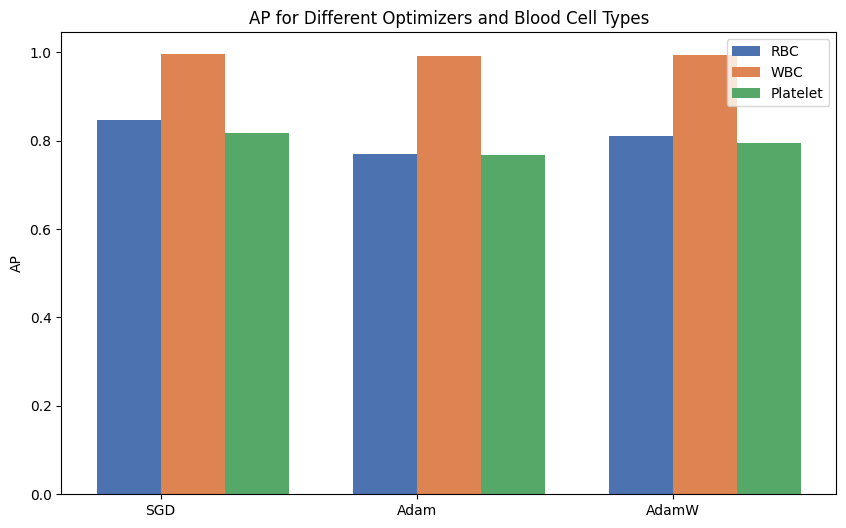

In [32]:
import seaborn as sns

# Set color palette
sns.set_palette('deep')

# Blood cell types
cell_types = ['RBC', 'WBC', 'Platelet']

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Width of a bar 
barWidth = 0.25

# Position of bars on x-axis
ind = np.arange(len(results))

for i, cell_type in enumerate(cell_types):
    ax.bar(ind + i*barWidth, [res['AP'][i] for res in results.values()], width = barWidth, color = sns.color_palette()[i], label = cell_type)

ax.set_xticks(ind + barWidth / 2)
ax.set_xticklabels(results.keys())
ax.set_title('AP for Different Optimizers and Blood Cell Types')
ax.set_ylabel('AP')
ax.legend()

plt.show()

From the mAP comparison using the validation set, SGD has the highest mAP score of 0.89, we will proceed with SGD optimizer in the final training.

### 5. Define the final model and optimizer 

In [17]:
model = get_model_instance_segmentation(num_classes=4) # 3 classes (RBC, WBC, Platelets) + background
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

### 6. Train Loop

In [19]:
from torch.utils.data import DataLoader
from tqdm import tqdm

# Prepare data loaders
train_loader = DataLoader(train, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x))) 
test_loader = DataLoader(test, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        # print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()
        
        losses.backward()
        optimizer.step()
        optimizer.zero_grad()  
    
    print(f"Epoch #{epoch+1} loss: {total_loss}")

100%|██████████| 103/103 [11:36<00:00,  6.76s/it]


Epoch #1 loss: 172.14112889766693


100%|██████████| 103/103 [11:30<00:00,  6.70s/it]


Epoch #2 loss: 114.34948348999023


100%|██████████| 103/103 [10:13<00:00,  5.96s/it]


Epoch #3 loss: 102.83478152751923


100%|██████████| 103/103 [10:47<00:00,  6.29s/it]


Epoch #4 loss: 93.69123560190201


100%|██████████| 103/103 [12:37<00:00,  7.36s/it]


Epoch #5 loss: 90.42525160312653


100%|██████████| 103/103 [11:49<00:00,  6.89s/it]


Epoch #6 loss: 82.61497747898102


100%|██████████| 103/103 [12:27<00:00,  7.26s/it]


Epoch #7 loss: 77.31712421774864


100%|██████████| 103/103 [12:06<00:00,  7.05s/it]


Epoch #8 loss: 72.42156159877777


100%|██████████| 103/103 [12:01<00:00,  7.01s/it]


Epoch #9 loss: 70.21132218837738


100%|██████████| 103/103 [12:04<00:00,  7.03s/it]

Epoch #10 loss: 68.64347618818283


### 7. Evaluate the model

In [20]:
# Evaluate the model on the test set
labels = []
preds_adj_all = []
annot_all = []
for im, annot in tqdm(test_loader, position = 0, leave = True):
        annot = [{k: v.to(device) for k, v in t.items()} for t in annot]
        im = list(img.to(device) for img in im)

        for t in annot:
            labels += t['labels']

        with torch.no_grad():
            preds_adj = make_prediction(model, im, 0.5) # Only keep predictions with a score > 0.5
            preds_adj = [{k: v.to(device) for k, v in t.items()} for t in preds_adj]
            preds_adj_all.append(preds_adj)
            annot_all.append(annot)
            
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += utils.get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 

true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))]  # all the batches get concatenated

true_positives = true_positives.to(device)
pred_scores = pred_scores.to(device)
pred_labels = pred_labels.to(device)
labels_tensor = torch.tensor(labels).to(device)

precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(AP.float())
print(f'mAP : {mAP}')
print(f'AP : {AP}')

100%|██████████| 72/72 [01:31<00:00,  1.26s/it]

mAP : 0.8743352890014648
AP : tensor([0.8064, 0.9633, 0.8533])


### 7. Visualizing results with Test set

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def visualize_model_predictions_on_val_set(model, data_loader, device, threshold=0.5, num_images=5):
    model.eval()  # Set the model to evaluation mode
    images_processed = 0
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            predictions = model(images)
            
            # Visualize the predictions for the first image in the batch
            img = images[0].cpu().data  # Move the image tensor to CPU and convert to numpy
            draw_boxes(Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy()), predictions, targets, threshold=threshold)
            
            images_processed += 1
            if images_processed >= num_images:
                break

def draw_boxes(image, predictions, targets, threshold=0.5):
    """
    Draws bounding boxes on the image based on the model's predictions.
    
    Args:
    - image (PIL Image): The image to draw on.
    - predictions (dict): The prediction output from the model for a single image.
    - targets (dict): The target output for a single image.
    - threshold (float): The minimum score for showing a prediction.
    """
    # Convert PIL image to a numpy array
    np_image = np.array(image)
    
    # Create a matplotlib figure and axis for plotting
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(np_image)

    # Extract predictions
    boxes = predictions[0]['boxes'].cpu().data.numpy()
    labels = predictions[0]['labels'].cpu().data.numpy()
    scores = predictions[0]['scores'].cpu().data.numpy()

    # Extract the target labels
    target_boxes = targets[0]['boxes'].cpu().data.numpy()
    target_labels = targets[0]['labels'].cpu().data.numpy()

    # Create a dictionary to map the label numbers to their original names
    label_dict = {1: 'RBC', 2: 'WBC', 3: 'Platelets'}

    # Draw each predicted bounding box 
    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x, y, xmax, ymax = box
            rect = patches.Rectangle((x, y), xmax - x, ymax - y, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x+3.25, y-5.5, f'Predicted Label: {label_dict[label]}, Score: {score:.2f}', bbox=dict(facecolor='r', alpha=0.5), fontsize=7)

    # Draw each target bounding box         
    for box, label in zip(target_boxes, target_labels):
        x, y, xmax, ymax = box
        rect = patches.Rectangle((x, y), xmax - x, ymax - y, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(x+3.25, y-5.5, label_dict[label], bbox=dict(facecolor='g', alpha=0.5), fontsize=7)
    plt.axis('off')  # Turn off axis
    plt.show()

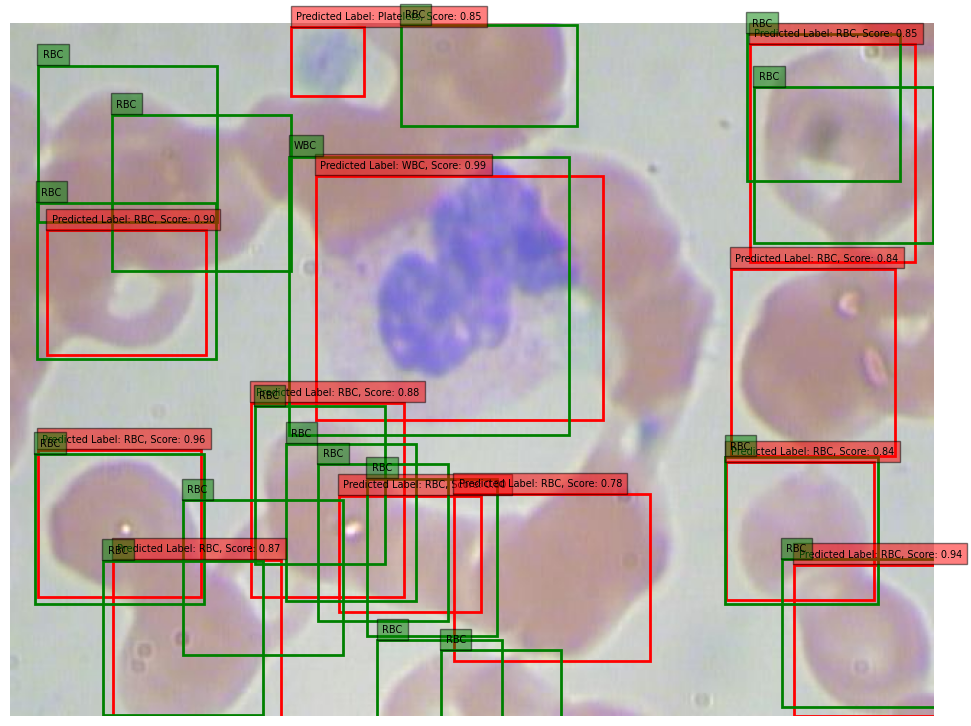

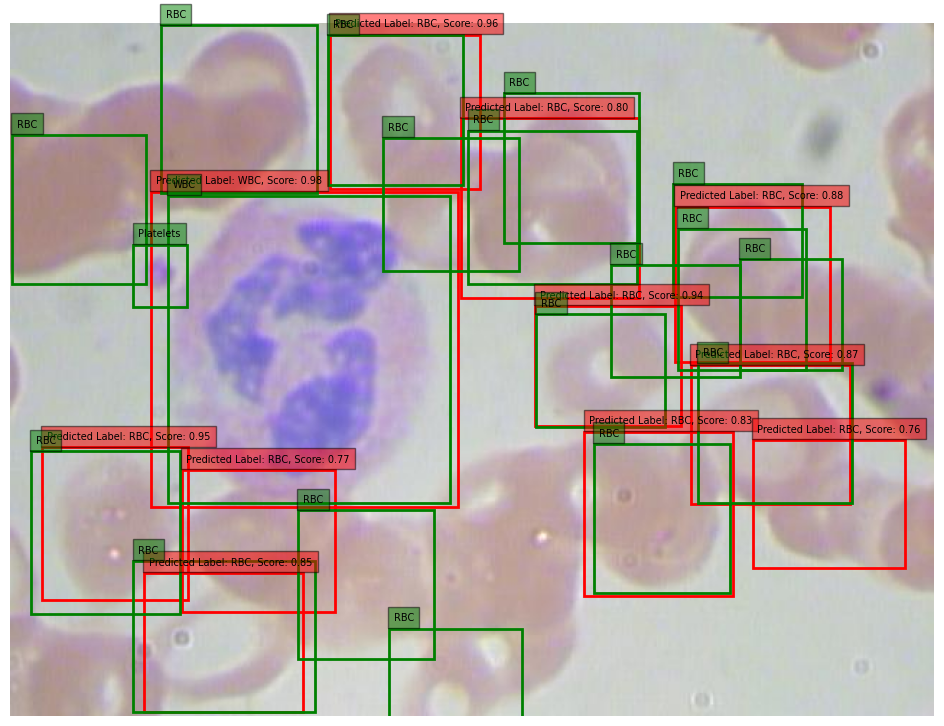

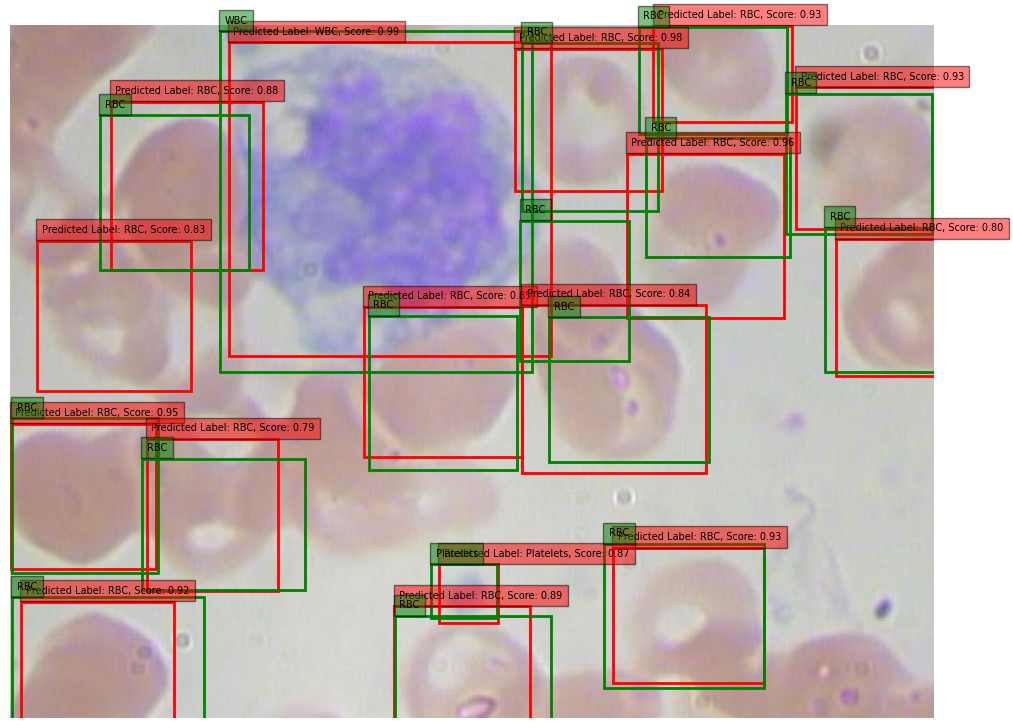

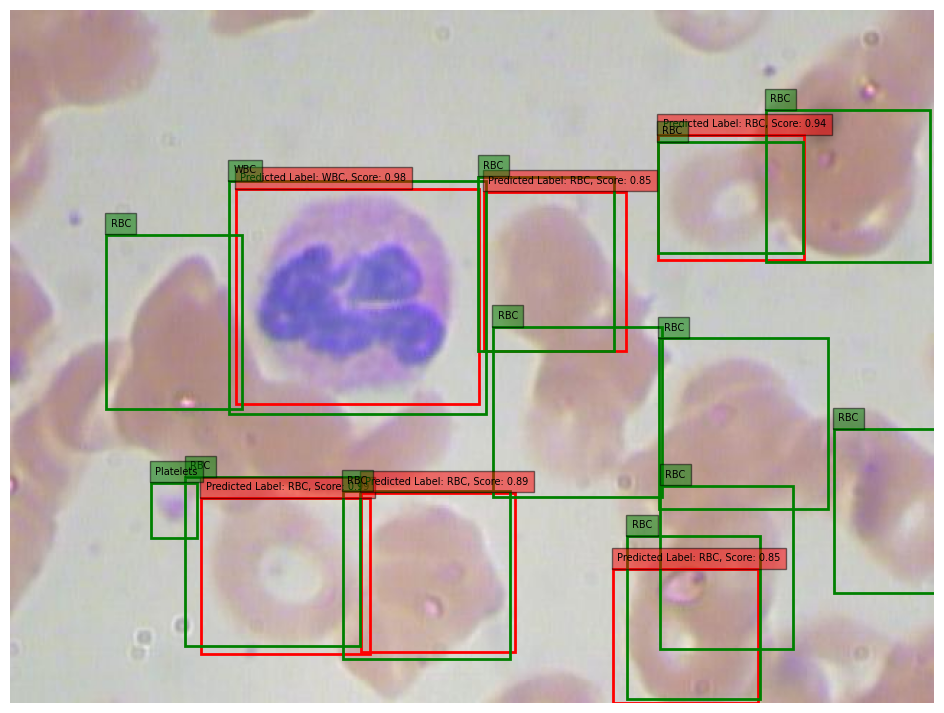

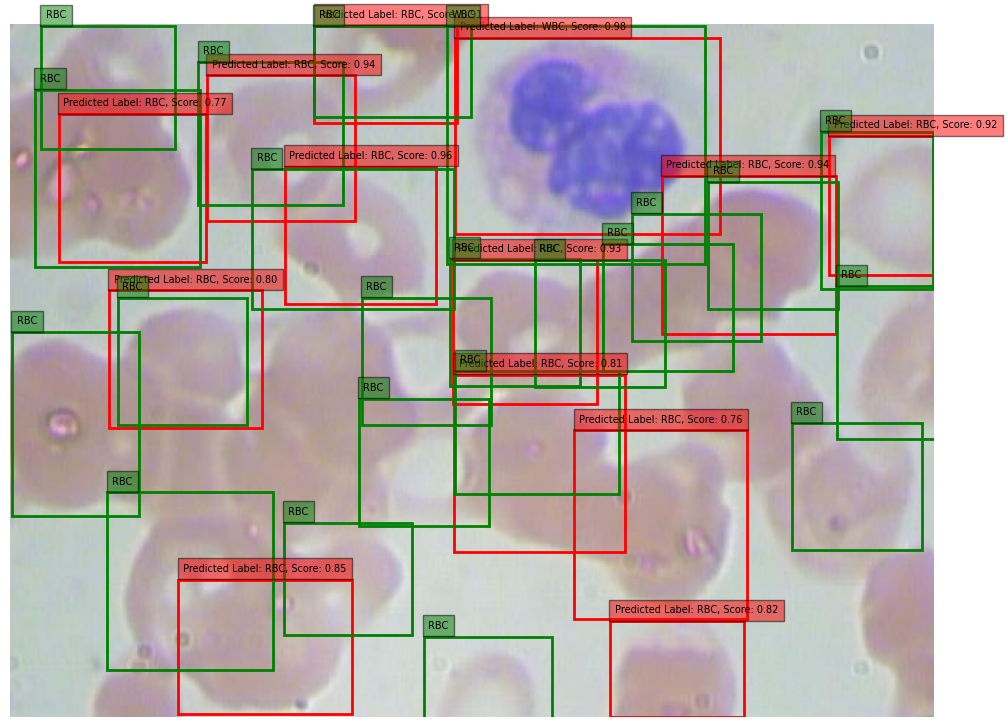

In [31]:
visualize_model_predictions_on_val_set(model, test_loader, device, num_images=5, threshold=0.75)